In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv("!merged_metadata_feature3.csv")
df = df.drop(columns=["alias"], errors="ignore")
df = df.dropna(subset=["parkinson"])
df["parkinson"] = df["parkinson"].astype(int)

# 2. 제외할 feature 리스트 (VIF + 상관계수 기반)
excluded_features = [
    'Acidisphaera', 'Acinetobacter', 'Aeribacillus', 'Aeromicrobium', 'Aggregatibacter',
    'Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium', 'Aquabacterium', 'Arcobacter',
    'Bdellovibrio', 'Bosea', 'Brachybacterium', 'Bradyrhizobium', 'Brevibacterium',
    'Brevundimonas', 'Caldalkalibacillus', 'Camelimonas', 'Candidatus_Saccharimonas',
    'Capnocytophaga', 'Cellvibrio', 'Centipeda', 'Cereibacter', 'Chalicogloea_CCALA_975',
    'Chryseomicrobium', 'Deinococcus', 'Delftia', 'Demequina', 'Domibacillus', 'Eikenella',
    'Exiguobacterium', 'F0058', 'Faecalicoccus', 'Fastidiosipila', 'Ferruginibacter',
    'Finegoldia', 'Flavobacterium', 'Gemella', 'Gemmobacter', 'Geobacillus', 'Georgenia',
    'Gordonia', 'Granulicatella', 'Haematobacter', 'Haemophilus', 'Hafnia-Obesumbacterium',
    'Halomonas', 'Helicobacter', 'Herbinix', 'Hydrogenophaga', 'Iamia', 'Idiomarina',
    'Ileibacterium', 'Ilumatobacter', 'JG30-KF-CM45', 'Janibacter', 'Jeotgalicoccus',
    'Kocuria', 'Kosakonia', 'Lachnoanaerobaculum', 'Lachnospiraceae_UCG-002', 'Lawsonella',
    'Leptotrichia', 'Macrococcus', 'Marinococcus', 'Marmoricola', 'Merdibacter',
    'Methylobacterium-Methylorubrum', 'Microlunatus', 'Mogibacterium', 'Moraxella',
    'Mucispirillum', 'Muribaculum', 'Mycobacterium', 'Negativicoccus', 'Nocardioides',
    'Nosocomiicoccus', 'Oceanobacillus', 'Odoribacter', 'Oligella', 'Olsenella',
    'Oribacterium', 'Ornithinibacter', 'Paenibacillus', 'Paraprevotella', 'Pedobacter',
    'Photobacterium', 'Phyllobacterium', 'Plectosphaerella', 'Polaromonas', 'Porphyromonas',
    'Prevotellaceae_UCG-003', 'Providencia', 'Pseudochrobactrum', 'Pseudoramibacter',
    'Pseudoxanthomonas', 'Psychrobacter', 'Rheinheimera', 'Rhodoferax', 'Robinsoniella',
    'Roseomonas', 'S5-A14a', 'SC-I-84', 'Sanguibacteroides', 'Scardovia', 'Schlegelella',
    'Skermanella', 'Sneathia', 'Sphaerotilus', 'Sphingobacterium', 'Sphingobium',
    'Stenotrophomonas', 'Synergistes', 'Syntrophococcus', 'Syntrophomonas', 'TM7x',
    'Tepidimonas', 'Terrimicrobium', 'Tissierella', 'Treponema', 'Vagococcus',
    'Vicinamibacteraceae', 'Vulcaniibacterium', 'W5053', 'Xanthomonas', 'Zoogloea',
    '[Eubacterium]_nodatum_group', '37-13', '67-14', 'A2', 'ASF356', 'Acetatifactor',
    'Acidovorax', 'Actinomycetospora', 'Aerococcus', 'Afipia', 'Alcaligenes', 'Alcanivorax',
    'Aliterella', 'Anoxybacillus', 'Lachnospiraceae_UCG-007', 'Facklamia', 'Ralstonia',
    'Burkholderia-Caballeronia-Paraburkholderia', 'Cupriavidus', 'Variovorax', 'Anaerococcus',
    'Glutamicibacter', 'Dolosigranulum', 'Erysipelotrichaceae', 'Enhydrobacter',
    'Diaphorobacter', 'Cutibacterium', 'Wolbachia', 'Paracoccus', 'Chryseobacterium',
    'Butyricimonas', 'Faecalitalea', 'Dubosiella', 'Catenibacterium', 'DS-100',
    '[Eubacterium]_brachy_group', 'Coprobacillus', 'Dielma', 'Coprobacter', 'Holdemania',
    'Corynebacterium', 'Oscillospira', 'Saccharimonadaceae', 'Bacteroides', 'NK4A214_group',
    'Acidaminococcus', 'Lautropia', 'Peptoniphilus', 'Enterobacter', 'Hungatella',
    'Pseudomonas', 'Rikenella', 'Desulfitibacter', 'Raoultibacter', 'Holdemanella',
    'GCA-900066755', 'Eubacterium', 'Solobacterium', 'Saccharimonadales', 'Neisseria',
    'Actinobacillus', 'Mitochondria', 'Actinomyces', 'Intestinimonas', 'Desulfovibrio',
    'Parabacteroides', 'Acetanaerobacterium', 'Alistipes', '[Clostridium]_innocuum_group',
    'GCA-900066575', 'Fusobacterium', 'Christensenella', 'uncultured', 'Barnesiella',
    'Collinsella', 'UCG-010', 'Izemoplasmatales', 'Phascolarctobacterium', 'Mobiluncus',
    'Enterococcus', '[Eubacterium]_hallii_group', 'Clostridioides', 'Flavonifractor',
    'Parvimonas', 'Chloroplast', 'UCG-003'
]

# 3. Feature & Target 분리
X = df.drop(columns=["sample_id", "parkinson"] + excluded_features, errors="ignore")
y = df["parkinson"]

# 4. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. LassoCV로 feature selection
lasso = LassoCV(cv=5, random_state=42, n_jobs=-1)
lasso.fit(X_scaled, y)
selected_features = X.columns[(lasso.coef_ != 0)]
print("선택된 feature 수:", len(selected_features))

X_selected = X[selected_features]

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

# 7. XGBoost 모델 학습
model = XGBClassifier(eval_metric='auc', use_label_encoder=False, random_state=42)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          early_stopping_rounds=10,
          verbose=True)

# 8. 성능 평가
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("Test AUROC:", round(auc, 4))

# 9. SHAP 분석
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# 10. 중요 feature 시각화
shap.summary_plot(shap_values, X_test)

c:\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


선택된 feature 수: 31


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

c:\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[선택된 피처 수] 149
[0]	eval-auc:0.67944
[1]	eval-auc:0.75852
[2]	eval-auc:0.76315
[3]	eval-auc:0.74815
[4]	eval-auc:0.76500
[5]	eval-auc:0.76333
[6]	eval-auc:0.76889
[7]	eval-auc:0.76852
[8]	eval-auc:0.77519
[9]	eval-auc:0.77926
[10]	eval-auc:0.78667
[11]	eval-auc:0.78963
[12]	eval-auc:0.78704
[13]	eval-auc:0.78778
[14]	eval-auc:0.78407
[15]	eval-auc:0.78704
[16]	eval-auc:0.78333
[17]	eval-auc:0.78222
[18]	eval-auc:0.78704
[19]	eval-auc:0.78667
[20]	eval-auc:0.79185
[21]	eval-auc:0.79037
[22]	eval-auc:0.79222
[23]	eval-auc:0.79333
[24]	eval-auc:0.79667
[25]	eval-auc:0.79630
[26]	eval-auc:0.79778
[27]	eval-auc:0.79593
[28]	eval-auc:0.79741
[29]	eval-auc:0.79519
[30]	eval-auc:0.79222
[31]	eval-auc:0.79444
[32]	eval-auc:0.79481
[33]	eval-auc:0.79889
[34]	eval-auc:0.79815
[35]	eval-auc:0.79778
[36]	eval-auc:0.79778
[37]	eval-auc:0.80000
[38]	eval-auc:0.79926
[39]	eval-auc:0.80000
[40]	eval-auc:0.79741
[41]	eval-auc:0.79667
[42]	eval-auc:0.79370
[43]	eval-auc:0.79815
[44]	eval-auc:0.79556
[45]	

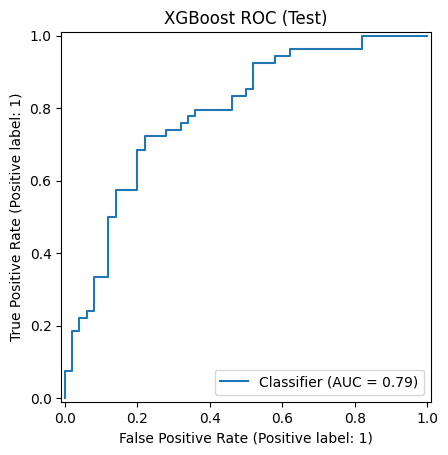

C:\Users\user\AppData\Local\Temp\ipykernel_18184\3628107912.py:177: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sel, show=True, max_display=30)


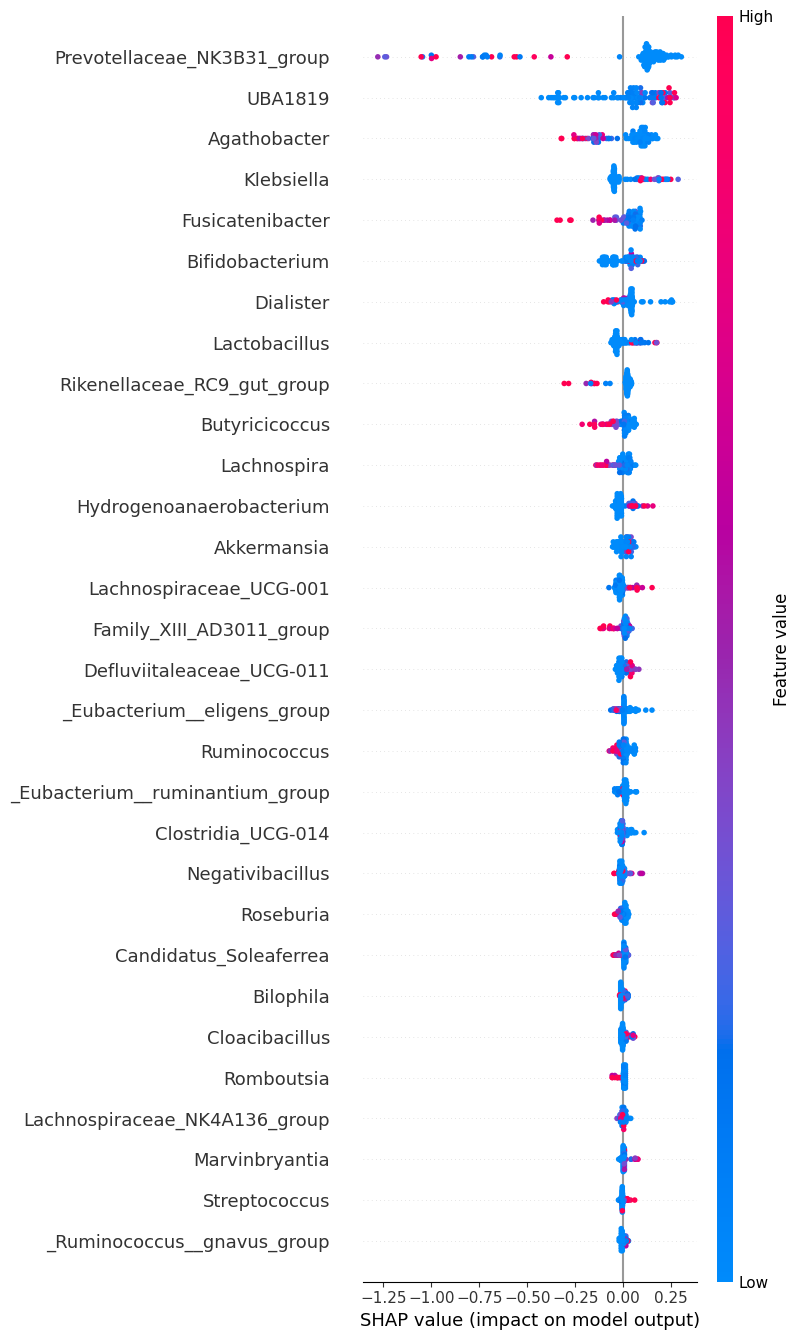


[SHAP 상위 20 피처 (|mean SHAP| 기준)]
Prevotellaceae_NK3B31_group: 0.322444
UBA1819: 0.157317
Agathobacter: 0.119552
Klebsiella: 0.079335
Fusicatenibacter: 0.067326
Bifidobacterium: 0.059101
Dialister: 0.051930
Lactobacillus: 0.043804
Rikenellaceae_RC9_gut_group: 0.041079
Butyricicoccus: 0.039566
Lachnospira: 0.034193
Hydrogenoanaerobacterium: 0.032336
Akkermansia: 0.024299
Lachnospiraceae_UCG-001: 0.024172
Family_XIII_AD3011_group: 0.023548
Defluviitaleaceae_UCG-011: 0.022975
_Eubacterium__eligens_group: 0.022766
Ruminococcus: 0.019432
_Eubacterium__ruminantium_group: 0.017355
Clostridia_UCG-014: 0.015223


In [16]:
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from xgboost.callback import EarlyStopping
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
import xgboost as xgb
import shap

# ==== 0. 환경설정 ====
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ==== 1. 데이터 로드 및 기본 전처리 ====
df = pd.read_csv("!merged_metadata_feature3.csv")
df = df.drop(columns=["alias"], errors="ignore")
df = df.dropna(subset=["parkinson"])
df["parkinson"] = df["parkinson"].astype(int)

excluded_features = [
    'Acidisphaera', 'Acinetobacter', 'Aeribacillus', 'Aeromicrobium', 'Aggregatibacter',
    'Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium', 'Aquabacterium', 'Arcobacter',
    'Bdellovibrio', 'Bosea', 'Brachybacterium', 'Bradyrhizobium', 'Brevibacterium',
    'Brevundimonas', 'Caldalkalibacillus', 'Camelimonas', 'Candidatus_Saccharimonas',
    'Capnocytophaga', 'Cellvibrio', 'Centipeda', 'Cereibacter', 'Chalicogloea_CCALA_975',
    'Chryseomicrobium', 'Deinococcus', 'Delftia', 'Demequina', 'Domibacillus', 'Eikenella',
    'Exiguobacterium', 'F0058', 'Faecalicoccus', 'Fastidiosipila', 'Ferruginibacter',
    'Finegoldia', 'Flavobacterium', 'Gemella', 'Gemmobacter', 'Geobacillus', 'Georgenia',
    'Gordonia', 'Granulicatella', 'Haematobacter', 'Haemophilus', 'Hafnia-Obesumbacterium',
    'Halomonas', 'Helicobacter', 'Herbinix', 'Hydrogenophaga', 'Iamia', 'Idiomarina',
    'Ileibacterium', 'Ilumatobacter', 'JG30-KF-CM45', 'Janibacter', 'Jeotgalicoccus',
    'Kocuria', 'Kosakonia', 'Lachnoanaerobaculum', 'Lachnospiraceae_UCG-002', 'Lawsonella',
    'Leptotrichia', 'Macrococcus', 'Marinococcus', 'Marmoricola', 'Merdibacter',
    'Methylobacterium-Methylorubrum', 'Microlunatus', 'Mogibacterium', 'Moraxella',
    'Mucispirillum', 'Muribaculum', 'Mycobacterium', 'Negativicoccus', 'Nocardioides',
    'Nosocomiicoccus', 'Oceanobacillus', 'Odoribacter', 'Oligella', 'Olsenella',
    'Oribacterium', 'Ornithinibacter', 'Paenibacillus', 'Paraprevotella', 'Pedobacter',
    'Photobacterium', 'Phyllobacterium', 'Plectosphaerella', 'Polaromonas', 'Porphyromonas',
    'Prevotellaceae_UCG-003', 'Providencia', 'Pseudochrobactrum', 'Pseudoramibacter',
    'Pseudoxanthomonas', 'Psychrobacter', 'Rheinheimera', 'Rhodoferax', 'Robinsoniella',
    'Roseomonas', 'S5-A14a', 'SC-I-84', 'Sanguibacteroides', 'Scardovia', 'Schlegelella',
    'Skermanella', 'Sneathia', 'Sphaerotilus', 'Sphingobacterium', 'Sphingobium',
    'Stenotrophomonas', 'Synergistes', 'Syntrophococcus', 'Syntrophomonas', 'TM7x',
    'Tepidimonas', 'Terrimicrobium', 'Tissierella', 'Treponema', 'Vagococcus',
    'Vicinamibacteraceae', 'Vulcaniibacterium', 'W5053', 'Xanthomonas', 'Zoogloea',
    '[Eubacterium]_nodatum_group', '37-13', '67-14', 'A2', 'ASF356', 'Acetatifactor',
    'Acidovorax', 'Actinomycetospora', 'Aerococcus', 'Afipia', 'Alcaligenes', 'Alcanivorax',
    'Aliterella', 'Anoxybacillus', 'Lachnospiraceae_UCG-007', 'Facklamia', 'Ralstonia',
    'Burkholderia-Caballeronia-Paraburkholderia', 'Cupriavidus', 'Variovorax', 'Anaerococcus',
    'Glutamicibacter', 'Dolosigranulum', 'Erysipelotrichaceae', 'Enhydrobacter',
    'Diaphorobacter', 'Cutibacterium', 'Wolbachia', 'Paracoccus', 'Chryseobacterium',
    'Butyricimonas', 'Faecalitalea', 'Dubosiella', 'Catenibacterium', 'DS-100',
    '[Eubacterium]_brachy_group', 'Coprobacillus', 'Dielma', 'Coprobacter', 'Holdemania',
    'Corynebacterium', 'Oscillospira', 'Saccharimonadaceae', 'Bacteroides', 'NK4A214_group',
    'Acidaminococcus', 'Lautropia', 'Peptoniphilus', 'Enterobacter', 'Hungatella',
    'Pseudomonas', 'Rikenella', 'Desulfitibacter', 'Raoultibacter', 'Holdemanella',
    'GCA-900066755', 'Eubacterium', 'Solobacterium', 'Saccharimonadales', 'Neisseria',
    'Actinobacillus', 'Mitochondria', 'Actinomyces', 'Intestinimonas', 'Desulfovibrio',
    'Parabacteroides', 'Acetanaerobacterium', 'Alistipes', '[Clostridium]_innocuum_group',
    'GCA-900066575', 'Fusobacterium', 'Christensenella', 'uncultured', 'Barnesiella',
    'Collinsella', 'UCG-010', 'Izemoplasmatales', 'Phascolarctobacterium', 'Mobiluncus',
    'Enterococcus', '[Eubacterium]_hallii_group', 'Clostridioides', 'Flavonifractor',
    'Parvimonas', 'Chloroplast', 'UCG-003'
]

# ==== 2. 컬럼명 클린업 (XGBoost 안전 모드) ====
# XGBoost가 [, ], <, > 포함한 feature_names를 싫어하므로 안전한 이름으로 치환
def clean_name(s: str) -> str:
    s = str(s)
    s = re.sub(r"[\[\]<>]", "_", s)
    s = re.sub(r"\s+", "_", s.strip())
    return s

rename_map = {col: clean_name(col) for col in df.columns}
df = df.rename(columns=rename_map)

# 제외 리스트도 동일 규칙으로 정리
excluded_features_clean = [clean_name(f) for f in excluded_features]

# ==== 3. Feature/Target 분리 ====
feature_drop = ["sample_id", "parkinson"] + excluded_features_clean
X = df.drop(columns=[c for c in feature_drop if c in df.columns], errors="ignore")
y = df["parkinson"]

# 모든 feature를 문자열 컬럼명으로 강제 (안전)
X.columns = X.columns.astype(str)

# ==== 4. Train/Test Split (누수 방지) ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# ==== 5. L1-로지스틱 기반 피처 셀렉션 ====
# - 표준화는 파이프라인 안에서 train에만 fit
# - CV 기준으로 AUROC 최적화
logit_pipe = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("logit",  LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty="l1",
        solver="saga",
        scoring="roc_auc",
        n_jobs=-1,
        refit=True,
        random_state=RANDOM_STATE,
        max_iter=5000
    ))
])

logit_pipe.fit(X_train, y_train)

# 선택된 피처(계수 ≠ 0)
coef = logit_pipe.named_steps["logit"].coef_
support = (coef != 0).any(axis=0)  # multiclass 대비, 여기선 binary라 한 줄
selected_features = X_train.columns[support].tolist()

if len(selected_features) == 0:
    warnings.warn("선택된 피처가 0개입니다. 규제가 과도한지 확인하세요(C값 늘리기 등).")
else:
    print(f"[선택된 피처 수] {len(selected_features)}")

X_train_sel = X_train[selected_features].copy()
X_test_sel  = X_test[selected_features].copy()

# ==== 6. XGBoost 학습 (Booster API + early stopping) ====
import xgboost as xgb

# DMatrix로 변환
dtrain = xgb.DMatrix(X_train_sel, label=y_train)
dtest  = xgb.DMatrix(X_test_sel,  label=y_test)

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.03,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": RANDOM_STATE,
    "tree_method": "hist",
}

booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=[(dtest, "eval")],
    early_stopping_rounds=50,
)

print("best_iteration:", booster.best_iteration)
print("best_score:", booster.best_score)


# ==== 7. 성능 평가 ====
y_pred_proba = booster.predict(dtest)  # 확률 벡터
auc = roc_auc_score(y_test, y_pred_proba)
print(f"[Test AUROC] {auc:.4f}")

RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title("XGBoost ROC (Test)")
plt.show()

# ==== 8. SHAP 해석 ====
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test_sel, check_additivity=False)

shap.summary_plot(shap_values, X_test_sel, show=True, max_display=30)

mean_abs = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(mean_abs)[::-1][:20]
top_feats = [(X_test_sel.columns[i], float(mean_abs[i])) for i in top_idx]
print("\n[SHAP 상위 20 피처 (|mean SHAP| 기준)]")
for f, v in top_feats:
    print(f"{f}: {v:.6f}")


In [20]:
# ==== (시각화 전용) 필요한 import ====
from sklearn.metrics import (
    precision_recall_curve, roc_curve, confusion_matrix
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs("eval_outputs", exist_ok=True)

# -------------------------------------------------
# A. ROC Curve (수치 표기 없음)
# -------------------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.tight_layout()
plt.savefig("eval_outputs/plot_roc.png", dpi=150)
plt.close()

# -------------------------------------------------
# B. Precision–Recall Curve (수치 표기 없음)
# -------------------------------------------------
prec, rec, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(rec, prec, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.savefig("eval_outputs/plot_pr.png", dpi=150)
plt.close()

# -------------------------------------------------
# C. Calibration Curve (신뢰도 다이어그램, 수치 표기 없음)
# -------------------------------------------------
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy="quantile")
plt.figure()
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(prob_pred, prob_true, marker="o", linewidth=2)
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve (10-bin)")
plt.tight_layout()
plt.savefig("eval_outputs/plot_calibration.png", dpi=150)
plt.close()

# -------------------------------------------------
# D. 클래스별 예측확률 분포 (수치 표기 없음)
# -------------------------------------------------
plt.figure()
plt.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.6, label="Control")
plt.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.6, label="PD")
plt.xlabel("Predicted probability (PD)")
plt.ylabel("Count")
plt.title("Score Distribution by Class")
plt.legend()
plt.tight_layout()
plt.savefig("eval_outputs/plot_score_hist_by_class.png", dpi=150)
plt.close()

# -------------------------------------------------
# E. Confusion Matrix Heatmap (최적 임계값: F1 최대 기준, 숫자 라벨 미표기)
# -------------------------------------------------
# F1 최대 임계값 계산
prec_, rec_, th_ = precision_recall_curve(y_test, y_pred_proba)
f1s = []
for p, r in zip(prec_[:-1], rec_[:-1]):  # 마지막 지점 제외
    f1s.append(0.0 if (p + r) == 0 else (2*p*r/(p+r)))
best_idx = int(np.argmax(f1s))
best_th = th_[best_idx] if len(th_) > 0 else 0.5

y_pred_bin = (y_pred_proba >= best_th).astype(int)
cm = confusion_matrix(y_test, y_pred_bin)

plt.figure()
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix (threshold by max F1)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Control", "PD"], rotation=0)
plt.yticks(tick_marks, ["Control", "PD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("eval_outputs/plot_confusion_matrix.png", dpi=150)
plt.close()

# -------------------------------------------------
# F. SHAP: 상위 20개 수평 막대 그래프 (숫자 표기 없음)
#  - 위에서 만든 top_feats 사용: List[Tuple(feature, mean_abs_SHAP)]
# -------------------------------------------------
top20_feats = top_feats[:20]
feat_names = [f for f, _ in top20_feats][::-1]        # 바 차트 위에서부터
feat_vals  = [v for _, v in top20_feats][::-1]

plt.figure(figsize=(6, max(4, len(top20_feats)*0.35)))
plt.barh(range(len(top20_feats)), feat_vals)
plt.yticks(range(len(top20_feats)), feat_names)
plt.xlabel("|mean SHAP value|")
plt.title("Top 20 Features by SHAP (Test)")
plt.tight_layout()
plt.savefig("eval_outputs/plot_shap_top20_barh.png", dpi=150)
plt.close()

# -------------------------------------------------
# G. (옵션) Top-K 간소화 모델 성능 비교 시각화 (수치 라벨 없이 막대 높이만)
#  - 위에서 booster_k, y_proba_k 등을 만든 경우에만 실행
# -------------------------------------------------
# 재학습 블록을 이미 돌렸다면, 간단 비교용 막대 그래프:
try:
    # 전체 선택 모델 vs TopK 모델 두 가지의 곡선 자체를 비교 플롯(곡선 덮어쓰기)
    # 1) ROC 비교
    fpr_k, tpr_k, _ = roc_curve(y_test, y_proba_k)
    plt.figure()
    plt.plot(fpr,   tpr,   linewidth=2, label="All selected")
    plt.plot(fpr_k, tpr_k, linewidth=2, label="TopK (by SHAP)")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Comparison")
    plt.legend()
    plt.tight_layout()
    plt.savefig("eval_outputs/plot_roc_compare_all_vs_topk.png", dpi=150)
    plt.close()

    # 2) PR 비교
    prec_k, rec_k, _ = precision_recall_curve(y_test, y_proba_k)
    plt.figure()
    plt.plot(rec,   prec,   linewidth=2, label="All selected")
    plt.plot(rec_k, prec_k, linewidth=2, label="TopK (by SHAP)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("PR Curve Comparison")
    plt.legend()
    plt.tight_layout()
    plt.savefig("eval_outputs/plot_pr_compare_all_vs_topk.png", dpi=150)
    plt.close()
except NameError:
    # booster_k / y_proba_k 가 없으면 건너뜀
    pass



In [18]:
# ==== 7-1. 추가 평가지표 ====
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    balanced_accuracy_score, brier_score_loss
)

# 기본 threshold 0.5
y_pred_label = (y_pred_proba >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_proba)          # ROC AUC
pr_auc  = average_precision_score(y_test, y_pred_proba) # PR AUC (AP)
f1      = f1_score(y_test, y_pred_label)               # F1-score @0.5
bal_acc = balanced_accuracy_score(y_test, y_pred_label) # Balanced Accuracy @0.5
brier   = brier_score_loss(y_test, y_pred_proba)        # Brier Score (낮을수록 좋음)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR  AUC: {pr_auc:.4f}")
print(f"F1-score (thr=0.5): {f1:.4f}")
print(f"Balanced Acc (thr=0.5): {bal_acc:.4f}")
print(f"Brier Score: {brier:.4f}")


ROC AUC: 0.7856
PR  AUC: 0.7811
F1-score (thr=0.5): 0.7358
Balanced Acc (thr=0.5): 0.7311
Brier Score: 0.1896


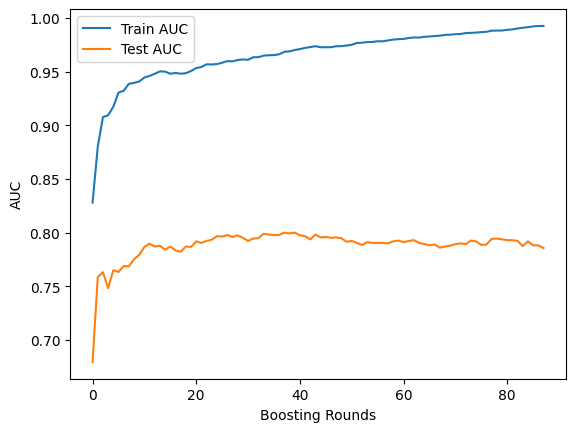

In [17]:
evals_result = {}
booster = xgb.train(
    params=params,
    dtrain=xgb.DMatrix(X_train_sel, label=y_train),
    num_boost_round=2000,
    evals=[(xgb.DMatrix(X_train_sel, label=y_train), "train"),
           (xgb.DMatrix(X_test_sel,  label=y_test),  "eval")],
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=False
)

# 곡선 시각화
plt.plot(evals_result['train']['auc'], label='Train AUC')
plt.plot(evals_result['eval']['auc'], label='Test AUC')
plt.xlabel("Boosting Rounds")
plt.ylabel("AUC")
plt.legend()
plt.show()


parkinson
1    268
0    252
Name: count, dtype: int64
parkinson
1    0.515385
0    0.484615
Name: proportion, dtype: float64


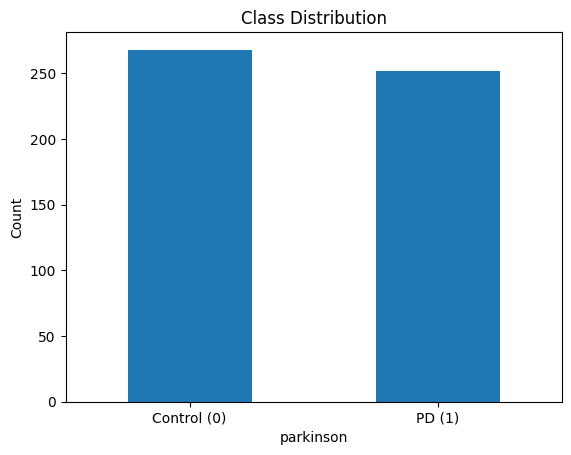

In [7]:
# 클래스 분포 확인
print(y.value_counts())                 # 개수
print(y.value_counts(normalize=True))   # 비율

# 시각화 (막대그래프)
import matplotlib.pyplot as plt
y.value_counts().plot(kind='bar')
plt.xticks([0, 1], ['Control (0)', 'PD (1)'], rotation=0)
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


In [4]:
import xgboost as xgb, inspect
print("xgboost version:", xgb.__version__, "path:", xgb.__file__)
import xgboost.sklearn as xgbs
print("fit signature:", inspect.signature(xgbs.XGBClassifier.fit))


xgboost version: 3.0.3 path: c:\Python\Python311\Lib\site-packages\xgboost\__init__.py
fit signature: (self, X: Any, y: Any, *, sample_weight: Optional[Any] = None, base_margin: Optional[Any] = None, eval_set: Optional[Sequence[Tuple[Any, Any]]] = None, verbose: Union[bool, int, NoneType] = True, xgb_model: Union[xgboost.core.Booster, str, xgboost.sklearn.XGBModel, NoneType] = None, sample_weight_eval_set: Optional[Sequence[Any]] = None, base_margin_eval_set: Optional[Sequence[Any]] = None, feature_weights: Optional[Any] = None) -> 'XGBClassifier'
